In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import seaborn as sns
import umap

c:\Users\schni\OneDrive\Documents\Switzerland\Bottmedical\.venv\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\schni\OneDrive\Documents\Switzerland\Bottmedical\.venv\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\schni\OneDrive\Documents\

In [2]:
# Import the batch file

batch_path = os.path.join(os.getcwd(), "Batch_runs_convolution")
file_path = os.path.join(batch_path, "Default_batch_5.csv")
try_batch = pd.read_csv(file_path)
try_batch = try_batch.iloc[:,1:]

In [3]:
# Separate each run into a separate df

grouped = try_batch.groupby('RunId')
batch_by_runs = {name: group for name, group in grouped}    

48 Final_State    Prey domination
dtype: object


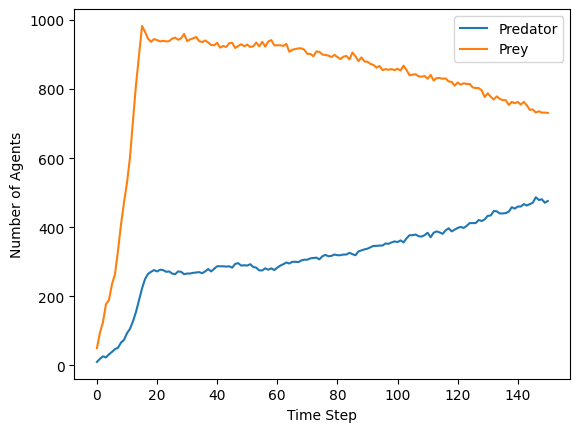

199 Final_State    Prey domination
dtype: object


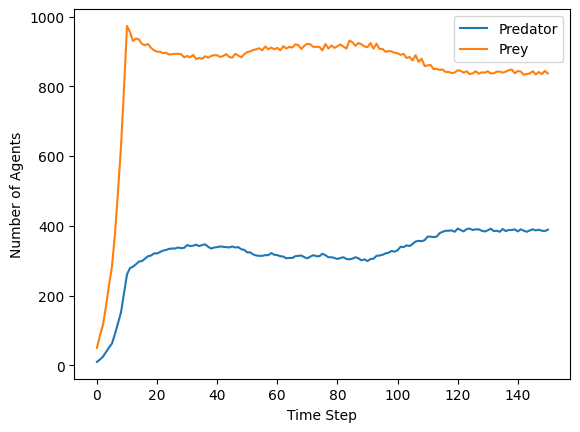

363 Final_State    Prey domination
dtype: object


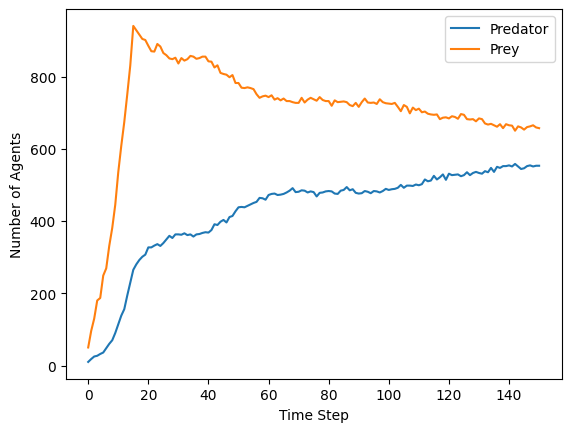

538 Final_State    Prey domination
dtype: object


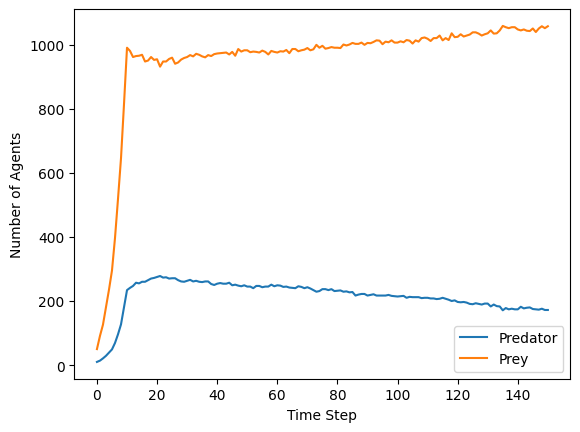

687 Final_State    Prey domination
dtype: object


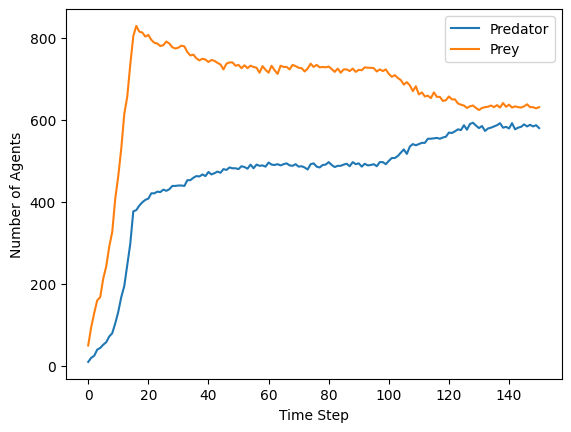

857 Final_State    Prey domination
dtype: object


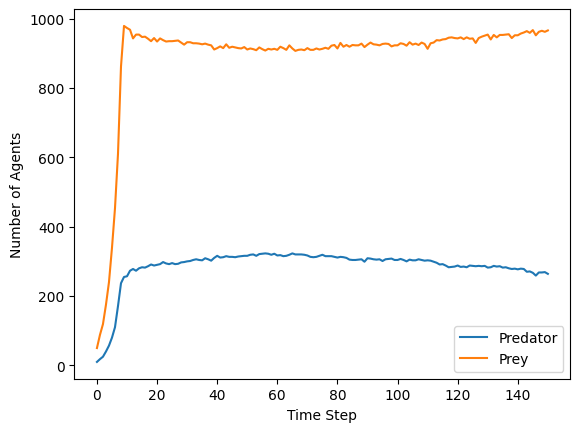

1019 Final_State    Prey domination
dtype: object


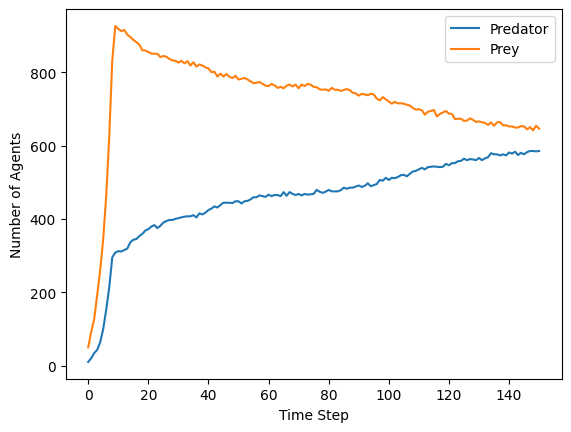

1173 Final_State    Prey domination
dtype: object


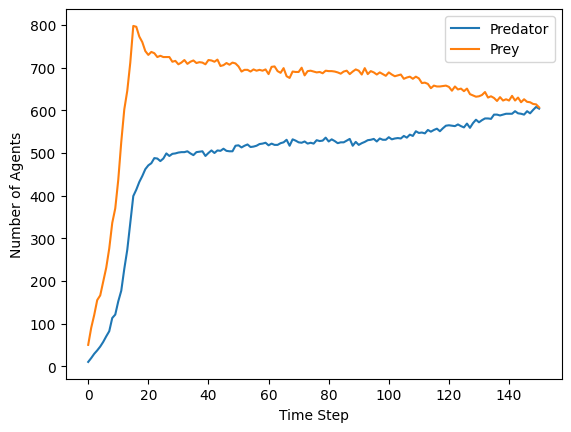

1489 Final_State    Prey domination
dtype: object


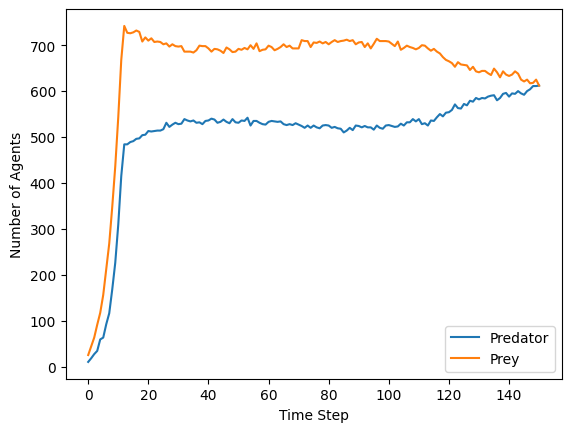

1497 Final_State    Prey domination
dtype: object


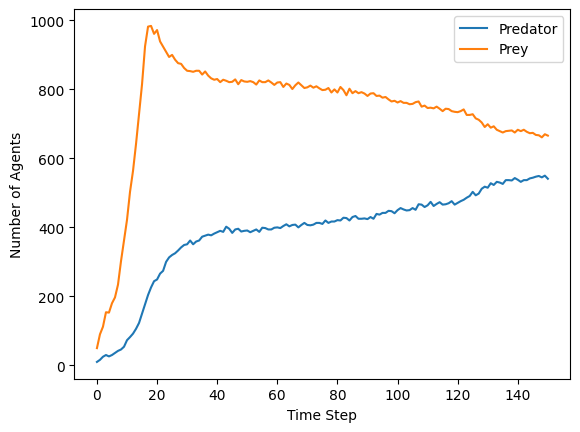

1500 Final_State    Prey domination
dtype: object


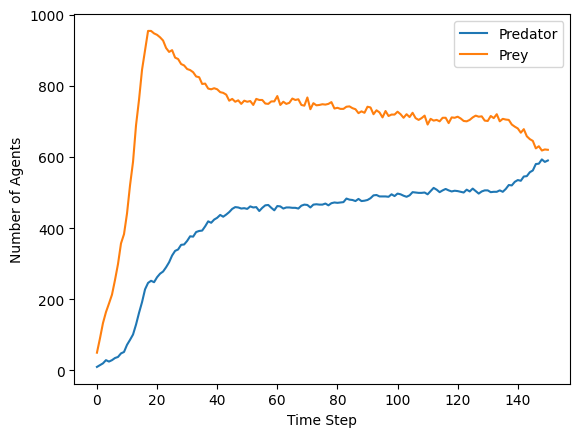

In [4]:
# Create a dataframe that summarizes all iterations of the batch run with inital conditions and final classification of the iteration

batch_summary = pd.Series()

for category, frame in batch_by_runs.items():
    initial_conditions = frame.loc[:,["RunId", "num_type_a_1", "num_type_a_2", "is_torus", "grid_height", "grid_width", "immediate_killing", "aggressiveness", "avrg_viability_time_type_a", "A1_Initial_Edge_Distance", "A2_Initial_Edge_Distance", "A1_Initial_Aggressiveness", "A2_Initial_Competition_Index"]].iloc[0]

    n_predator = frame.loc[:, "A1_Number"]
    n_prey = frame.loc[:, "A2_Number"]

    n_steps = pd.Series(frame.loc[:, "Step"].iloc[-1], index=["Steps_Number"])

    n_predator_final = n_predator.iloc[-1]
    n_prey_final = n_prey.iloc[-1]

    predator_slope = abs(n_predator_final - n_predator.iloc[100]) / 500
    prey_slope = abs(n_prey_final - n_prey.iloc[100]) / 500

    #Determine the final state. Steady state is assigned if the slope on the last 500 simualtion steps is less then 0.05
    # if n_predator_final == 0 and n_prey_final == 0:
    #     final_state = pd.Series("No bacteria survival", index=["Final_State"])
    if n_predator_final != 0 and n_prey_final == 0:
        final_state = pd.Series("Predator domination", index=["Final_State"])
    elif n_predator_final == 0 and n_prey_final != 0:
        final_state = pd.Series("Prey domination", index=["Final_State"])
    elif n_predator_final > n_prey_final:
        if predator_slope < 0.075 and prey_slope < 0.075:
            final_state = pd.Series("Steady state, predator domination", index=["Final_State"])
        else:
            final_state = pd.Series("Predator domination", index=["Final_State"])
    elif n_prey_final >= n_predator_final:
        if predator_slope < 0.075 and prey_slope < 0.75:
            final_state = pd.Series("Steady state, prey domination", index=["Final_State"])
        else:
            final_state = pd.Series("Prey domination", index=["Final_State"])

    time_steps = range(151)
    
    if (final_state == pd.Series("Prey domination", index=["Final_State"])).all():

        plt.plot(time_steps, n_predator, label = "Predator")
        plt.plot(time_steps, n_prey, label = "Prey")
        plt.legend()
        plt.xlabel('Time Step')
        plt.ylabel('Number of Agents')
        print(initial_conditions.loc["RunId"],final_state)
        plt.show()

    n_predator_final = pd.Series(n_predator_final, index=["A1_Final_Count"])
    n_prey_final = pd.Series(n_prey_final, index=["A2_Final_Count"])

    predator_slope = pd.Series(predator_slope, index=["A1_Slope"])
    prey_slope = pd.Series(prey_slope, index=["A2_Slope"])

    iteration_summary = pd.concat([final_state, initial_conditions, n_steps, n_predator_final, n_prey_final, predator_slope, prey_slope], axis = 0)
    batch_summary =  pd.concat([batch_summary, iteration_summary], axis = 1)

batch_summary = batch_summary.T
batch_summary = batch_summary.iloc[1:,:]
batch_summary.set_index('RunId', inplace=True)

In [5]:
# Get the summary of our variable of interest

batch_summary.Final_State.value_counts()

Final_State
Predator domination                  1373
Steady state, prey domination         141
Steady state, predator domination      95
Prey domination                        11
Name: count, dtype: int64

In [6]:
# Preprocess the batch summary

batch_summary["Predator_vs_Prey"] = batch_summary.loc[:, "num_type_a_1"] / batch_summary.loc[:, "num_type_a_2"]
batch_summary["Aggressiveness_deviation"] = batch_summary.loc[:, "A1_Initial_Aggressiveness"] - batch_summary.loc[:, "aggressiveness"]

def compare_and_fill(row):
    if row['A1_Initial_Edge_Distance'] > row['A2_Initial_Edge_Distance']:
        return True
    else:
        return False

batch_summary['Predator_closest_to_the_Edge'] = batch_summary.apply(compare_and_fill, axis=1)

max_variable_set = ["num_type_a_1", "num_type_a_2", "aggressiveness", "avrg_viability_time_type_a", "A1_Initial_Edge_Distance", "A2_Initial_Edge_Distance", "A1_Initial_Aggressiveness", "A2_Initial_Competition_Index", "A1_Final_Count", "A2_Final_Count"]

## Statistical View

In [7]:
# Separate final state category into a separate df

stats_variable_set = ["Final_State", "Predator_vs_Prey", "aggressiveness", "Aggressiveness_deviation", "avrg_viability_time_type_a", "Predator_closest_to_the_Edge", "A2_Initial_Competition_Index"]
batch_summary_stats = batch_summary[stats_variable_set]

# Separate by the final states
grouped_by_final_state = batch_summary_stats.groupby('Final_State')
batch_by_final_state = {name: group for name, group in grouped_by_final_state} 

In [8]:
# Separate by the ratios

grouped_by_ratio = batch_summary_stats.groupby('Predator_vs_Prey')
batch_by_ratio = {name: group for name, group in grouped_by_ratio} 

In [9]:
# Separate by the the viability time

grouped_by_viability = batch_summary_stats.groupby('avrg_viability_time_type_a')
batch_by_viability = {name: group for name, group in grouped_by_viability} 

In [10]:
# Separate by the the aggressiveness

grouped_by_aggressiveness = batch_summary_stats.groupby('aggressiveness')
batch_by_aggressiveness= {name: group for name, group in grouped_by_aggressiveness}

In [11]:
# Primary split overview

# Define final state to look at

fs = 50.0
batch_by_aggressiveness[fs].describe()

,Final_State,Predator_vs_Prey,aggressiveness,Aggressiveness_deviation,avrg_viability_time_type_a,Predator_closest_to_the_Edge,A2_Initial_Competition_Index
count,270,270.0,270.0,270.00,270,270,270.0
unique,4,7.0,1.0,210.00,3,2,69.0
top,Predator domination,1.0,50.0,-0.25,30,True,0.5
freq,242,90.0,270.0,3.00,90,145,43.0


In [12]:
batch_by_aggressiveness[fs].iloc[:,0].value_counts()

Final_State
Predator domination                  242
Steady state, prey domination         20
Steady state, predator domination      7
Prey domination                        1
Name: count, dtype: int64

In [13]:
batch_by_aggressiveness[fs].iloc[:,1:].median()

Predator_vs_Prey                 1.0
aggressiveness                  50.0
Aggressiveness_deviation        0.02
avrg_viability_time_type_a      40.0
Predator_closest_to_the_Edge     1.0
A2_Initial_Competition_Index     0.5
dtype: object

In [14]:
# Functiion to do secondary splits within the final states

def group_by_secondary_parameter(primary_split_object, secondary_split_dictionary, secondary_split_parameter):

    for category, frame in primary_split_object.items():

        grouped_by_secondary = frame.groupby(secondary_split_parameter)
        secondary_split_dictionary[category] = {name: group for name, group in grouped_by_secondary}
    

In [15]:
# Group each final state itself by the predator vs prey ratios

batch_by_final_state_and_ratio = {}

group_by_secondary_parameter(batch_by_final_state, batch_by_final_state_and_ratio, "Predator_vs_Prey")


### By Final State
*Prey can survive at initial ratios of 1:1 and lower; domination can occur at the lowest ratios, but is seldom. Aggressiveness variable is less intuittive than expected -> can be compensated by other varibles and thus allow prey survival at all agressiveness levels. Viability time appears to determine between steady state (higher) and domination (lower). Increased initial competition (important to note that it is not independent of the ratios) seems to be a key player in determining the simulation fate. No strong conclusions about the initial location.*
- **Predator domination (1373; 84.75% of all iterations)**
    - Ratios: 1:5 (52); 1:2.5 (110); 1:2 (157); 1:1 (514); 2:1 (180); 2.5:1 (180); 5:1 (180)
    - Aggressiveness: 1 (216); 2.5 (222); 5 (225); 10 (235); 25(233); 50(242)
    - Viability time: 30 (528); 40 (439); 50 (406)
    - Median initial competition index 0.51
    - 52% of times Predator closest to the edge
- **Steady state, predator domination (95; 5.86% of all iterations)**
    - Ratio: 1:5 (4); 1:2.5 (43); 1:2 (22); 1:1 (26)
    - Aggressiveness: 1 (27); 2.5 (19); 5 (18); 10 (12); 25(12); 50(7)
    - Viability time: 30 (4); 40 (34); 50 (57)
    - Median initial competition index 0.33
    - 56% of times Predator closest to the edge
- **Steady state, prey domination (141; 8.70% of all iterations)**
    - Ratio: 1:5 (114); 1:2.5 (26); 1:2 (1)
    - Aggressiveness: 1 (26); 2.5 (25); 5 (26); 10 (21); 25(23); 50(20)
    - Viability time: 30 (2); 40 (64); 50 (75)
    - Median initial competition index 0.17
    - 39% of times Predator closest to the edge
- **Prey domination (11; 0.68% of all iterations)**
    - Ratios: 1:5 (10); 1:2.5 (1)
    - Aggressiveness: 1 (1); 2.5 (4); 5 (1); 10 (2); 25(2); 50(1)
    - Viability time: 30 (6); 40 (3); 50 (2)
    - Median initial competition index 0.17
    - 45% of times Predator closest to the edge
    
### By Initial Ratios
*As expected increase in the ratio reduces the outcomes where the Prey can survive and increases the competition index.*
- **1:5 (180; 11.11%)**
    - Final State: Predator domination (52); Steady state, predator domination (4); Steady state, prey domination (114); Prey domination (10)
    - Median initial competition index 0.17
    - 46% of times Predator closest to the edge
- **1:2.5 (180; 11.11%)**
    - Final State: Predator domination (110); Steady state, predator domination (43); Steady state, prey domination (26); Prey domination (1)
    - Median initial competition index 0.29
    - 51% of times Predator closest to the edge
- **1:2 (180; 11.11%)**
    - Final State: Predator domination (157); Steady state, predator domination (22); Steady state, prey domination (1)
    - Median initial competition index 0.33
    - 57% of times Predator closest to the edge
- **1:1 (540; 33.33%)**
    - Final State: Predator domination (514); Steady state, predator domination (26)
    - Median initial competition index 0.50
    - 48% of times Predator closest to the edge
- **2:1 (180; 11.11%)**
    - Final State: Predator domination (180)
    - Median initial competition index 0.68
    - 54% of times Predator closest to the edge
- **2.5:1 (180; 11.11%)**
    - Final State: Predator domination (180)
    - Median initial competition index 0.73
    - 54% of times Predator closest to the edge
- **5:1 (180; 11.11%)**
    - Final State: Predator domination (180)
    - Median initial competition index 0.86
    - 52% of times Predator closest to the edge

### By Viability Time
*As shown before, lower values favor domination of one species over another, while higher ones increase the number of steady state outcomes.*
- **30 (540; 33.33%)**
    - Final State: Predator domination (528); Steady state, predator domination (4); Steady state, prey domination (2); Prey domination (6)
    - Median initial competition index 0.5
- **40 (540; 33.33%)**
    - Final State: Predator domination (439); Steady state, predator domination (34); Steady state, prey domination (64); Prey domination (3)
    - Median initial competition index 0.5
- **50 (540; 33.33%)**
    - Final State: Predator domination (406); Steady state, predator domination (57); Steady state, prey domination (75); Prey domination (2)
    - Median initial competition index 0.5

### By Aggressivenesss
*Suprisingly, aggressiveness does not seem to have a drastic influence on the simulation outcomes. For sure there are fluctuation if compared highes and lowest aggressiveness levels, but they are insignificant enough for a 50 fold increase.*
- **1 (270; 16.66%)**
    - Final State: Predator domination (216); Steady state, predator domination (27); Steady state, prey domination (26); Prey domination (1)
    - Median initial competition index 0.5
- **2.5 (270; 16.66%)**
    - Final State: Predator domination (222); Steady state, predator domination (19); Steady state, prey domination (24); Prey domination (4)
    - Median initial competition index 0.5
- **5 (270; 16.66%)**
    - Final State: Predator domination (225); Steady state, predator domination (18); Steady state, prey domination (26); Prey domination (1)
    - Median initial competition index 0.5
- **10 (270; 16.66%)**
    - Final State: Predator domination (235); Steady state, predator domination (12); Steady state, prey domination (21); Prey domination (2)
    - Median initial competition index 0.5
- **25 (270; 16.66%)**
    - Final State: Predator domination (233); Steady state, predator domination (12); Steady state, prey domination (23); Prey domination (2)
    - Median initial competition index 0.5
- **50 (270; 16.66%)**
    - Final State: Predator domination (242); Steady state, predator domination (7); Steady state, prey domination (20); Prey domination (1)
    - Median initial competition index 0.5


## PCA

In [16]:
# Create different sets of variables

reduced_variable_set = ["Predator_vs_Prey", "aggressiveness", "avrg_viability_time_type_a", "A1_Initial_Edge_Distance", "A2_Initial_Edge_Distance", "A1_Initial_Aggressiveness", "A2_Initial_Competition_Index"]
# Trash selection reduced_variable_set_1 = ["Predator_vs_Prey", "aggressiveness", "avrg_viability_time_type_a", "A1_Initial_Edge_Distance", "A2_Initial_Edge_Distance", "A1_Initial_Aggressiveness", "A2_Initial_Competition_Index"]
# Third trash selection reduced_variable_set_2 = ["Predator_vs_Prey", "aggressiveness", "avrg_viability_time_type_a", "A1_Initial_Edge_Distance", "A2_Initial_Edge_Distance", "A2_Initial_Competition_Index", "A1_Final_Count", "A2_Final_Count"]
# Forth trash selection reduced_variable_set_3 = ["Predator_vs_Prey", "Aggressiveness_deviation", "aggressiveness", "avrg_viability_time_type_a", "A1_Initial_Edge_Distance", "A2_Initial_Edge_Distance","A2_Initial_Competition_Index", "A1_Final_Count", "A2_Final_Count"]
# Second trash selection reduced_variable_set_4 = ["Predator_vs_Prey", "aggressiveness", "avrg_viability_time_type_a", "Predator_closest_to_the_Edge", "A1_Initial_Aggressiveness","A2_Initial_Competition_Index", "A1_Final_Count", "A2_Final_Count"]
# Forth trash selection reduced_variable_set_5 = ["Predator_vs_Prey", "Aggressiveness_deviation", "aggressiveness","avrg_viability_time_type_a", "Predator_closest_to_the_Edge", "A2_Initial_Competition_Index", "A1_Final_Count", "A2_Final_Count"]
# Trash selection min_variable_set = ["Predator_vs_Prey", "Aggressiveness_deviation", "avrg_viability_time_type_a", "Predator_closest_to_the_Edge", "A2_Initial_Competition_Index"]
# Trash selection min_variable_no_quantification_set = ["Predator_vs_Prey", "Aggressiveness_deviation", "avrg_viability_time_type_a", "Predator_closest_to_the_Edge"]
# Second trash selection no_quantification_set = ["num_type_a_1", "num_type_a_2", "aggressiveness", "avrg_viability_time_type_a", "A1_Final_Count", "A2_Final_Count"]

all_variable_combinations = [max_variable_set, reduced_variable_set]

In [17]:
# Compute PCA

batch_summary_pca = batch_summary[reduced_variable_set]
batch_summary_pca_scaled = StandardScaler().fit_transform(batch_summary_pca)

n_c = 3
pca = PCA(n_components=n_c)
batch_summary_pca_transformed = pca.fit_transform(batch_summary_pca_scaled)
batch_summary_pca_transformed_df = pd.DataFrame(
    data=batch_summary_pca_transformed, 
    columns=['PC1', 'PC2', "PC3"])
batch_summary_pca_transformed_df["Final_State"] = batch_summary["Final_State"]

pca.explained_variance_

array([2.00324997, 1.84876374, 1.06712445])

In [18]:
# Create the palette for plotting

custom_palette = [
    # sns.color_palette("pastel")[4],   # Pastel Purple
    sns.color_palette("Blues")[2],    # Darker Blue
    # sns.color_palette("Blues")[3],    # Medium Blue
    sns.color_palette("Blues")[4],    # Lighter Blue
    sns.color_palette("Oranges")[5],  # Darker Orange
    # sns.color_palette("Oranges")[4],  # Medium Orange
    sns.color_palette("Oranges")[3],  # Lighter Orange
]


c = [custom_palette[x] for x in batch_summary.Final_State.map(
        {#"No bacteria survival": 0,
        "Steady state, predator domination": 0,
        # "Pseudo-steady state, predator domination": 1, 
        "Predator domination": 1,
        "Steady state, prey domination": 2,
        # "Pseudo-steady state, prey domination": 4,
        "Prey domination": 3,
        }
        )]

In [34]:
# Plot PCAs against each other

def plot_pcas(pca1, pca2, title = "Principal Component Decomposition"):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(pca1, pca2, c = c)

    legend_labels = {
        # 0: "No bacteria survival",
        0: "Steady state, predator domination",
        # 2: "Pseudo-steady state, predator domination",
        1: "Predator domination",
        2: "Steady state, prey domination",
        # 5: "Pseudo-steady state, prey domination",
        3: "Prey domination",
    }

    # Create a list of Patch objects to use for the legend
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette[x], markersize=10, label=label) for x, label in legend_labels.items()]

    # Add the legend to the plot
    plt.legend(handles=legend_patches, title="Final States", bbox_to_anchor=(1, 1))
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title, fontsize=18)

    plt.show()


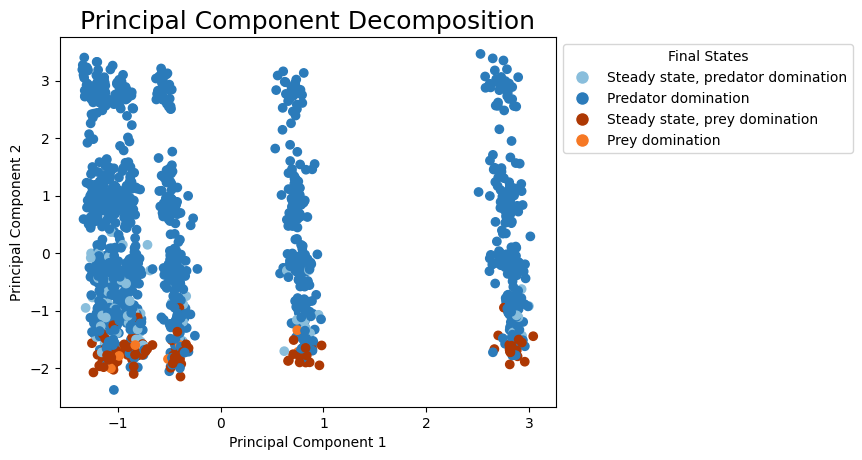

In [35]:
plot_pcas(batch_summary_pca_transformed_df["PC1"],batch_summary_pca_transformed_df["PC2"])

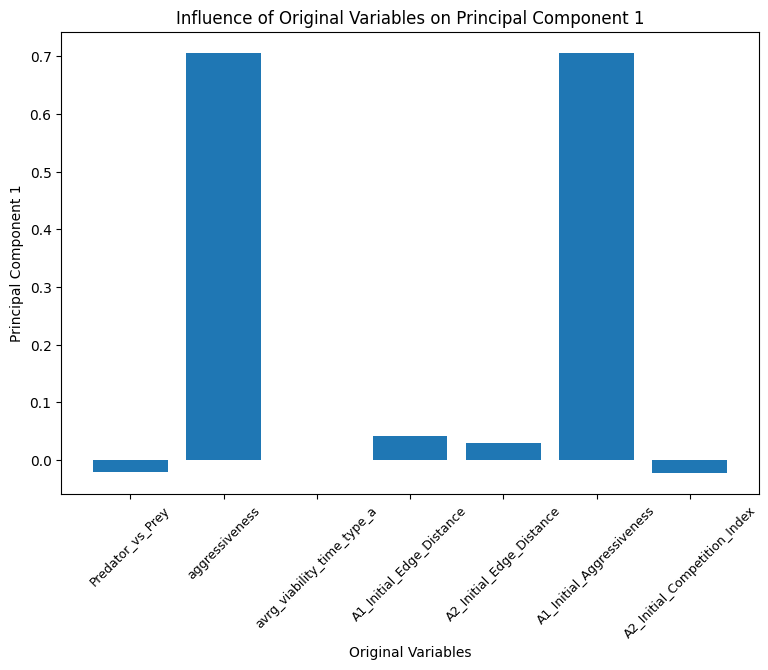

In [45]:
component_number = 0
loadings = pca.components_[component_number]

# Create a bar plot to visualize the influence of original variables on the chosen principal component
plt.figure(figsize=(9, 6))
plt.bar(batch_summary_pca.columns, loadings)
plt.title(f'Influence of Original Variables on Principal Component {component_number + 1}')
plt.xlabel('Original Variables')
plt.ylabel(f'Principal Component {component_number + 1}')
plt.xticks(rotation=45, fontsize=9)
plt.show()

## UMAP

In [69]:
# Function to play around with UMAP parameters

def draw_umap(variables_set, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(random_state = 10,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    
    preprocessed = batch_summary[variables_set]
    scaled = StandardScaler().fit_transform(preprocessed)
    u = fit.fit_transform(scaled)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c = c)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c = c)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,2], u[:,0], u[:,1], c = c, s=100)
        ax.set_xlabel('UMAP 3')
        ax.set_ylabel('UMAP 1')
        ax.set_zlabel('UMAP 2')

    legend_labels = {
        # 0: "No bacteria survival",
        0: "Steady state, predator domination",
        # 2: "Pseudo-steady state, predator domination",
        1: "Predator domination",
        2: "Steady state, prey domination",
        # 5: "Pseudo-steady state, prey domination",
        3: "Prey domination",
    }

    # Create a list of Patch objects to use for the legend
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette[x], markersize=10, label=label) for x, label in legend_labels.items()]

    # Add the legend to the plot
    plt.legend(handles=legend_patches, title="Final States", bbox_to_anchor=(2, 1))
    plt.title(title, fontsize=18)
    plt.show()
    
    return u

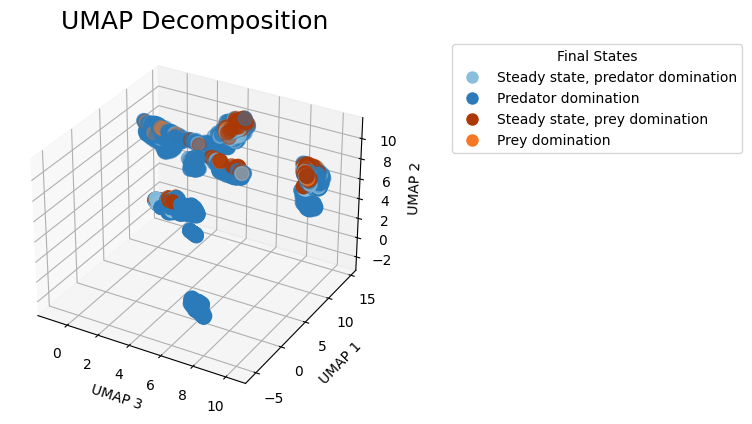

In [70]:
embeddings = []

dim_red = draw_umap(variables_set = reduced_variable_set, n_neighbors = 20, min_dist = 0.1, n_components = 3, title = "UMAP Decomposition")
embeddings.append(dim_red)

# 50 neighbors and a clustering distance equal to 0.75 seems to be optimal for a broader picture
# CONSIDER THE 3D REPRESENTATION   

# SECOND VARIABLE VISUALISATION SEEMS TO BE THE MOST DESCRIPTIVE ONE

In [24]:
def plot_embedding_vs_umap(embedding, features):

    for umap_x in range(embedding.shape[1]):

        for feature in features:

            plt.scatter(
                embedding[:, umap_x],
                batch_summary.loc[:, feature],
                c=[custom_palette[x] for x in batch_summary.Final_State.map(
                    {#"No bacteria survival": 0,
                    "Steady state, predator domination": 0,
                    # "Pseudo-steady state, predator domination": 2, 
                    "Predator domination": 1,
                    "Steady state, prey domination": 2,
                    # "Pseudo-steady state, prey domination": 5,
                    "Prey domination": 3,
                    }
                    )])
        
            plt.ylabel(f"{feature}")
            plt.xlabel(f"UMAP {umap_x+1}")


            legend_labels = {
                # 0: "No bacteria survival",
                0: "Steady state, predator domination",
                # 2: "Pseudo-steady state, predator domination",
                1: "Predator domination",
                2: "Steady state, prey domination",
                # 5: "Pseudo-steady state, prey domination",
                3: "Prey domination",
            }

            # Create a list of Patch objects to use for the legend
            legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette[x], markersize=10, label=label) for x, label in legend_labels.items()]
            # Add the legend to the plot
            plt.legend(handles=legend_patches, title="Final States", bbox_to_anchor=(1, 1))
            #plt.title(, fontsize=18)
            plt.show()

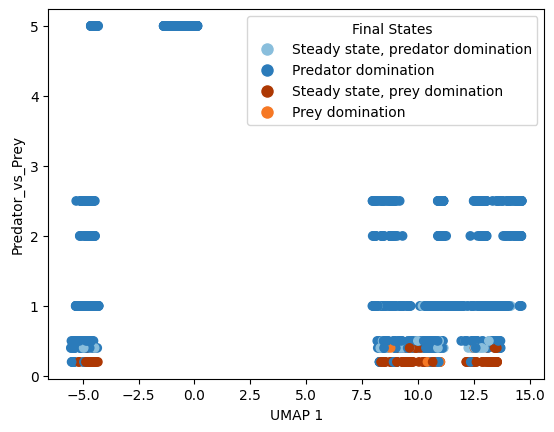

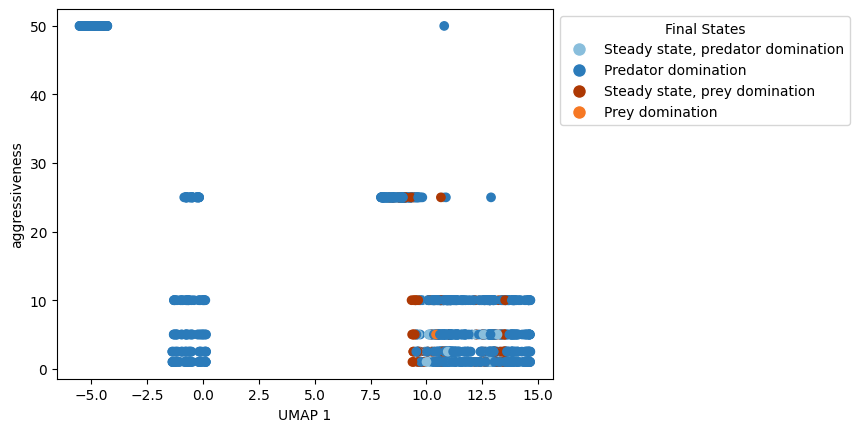

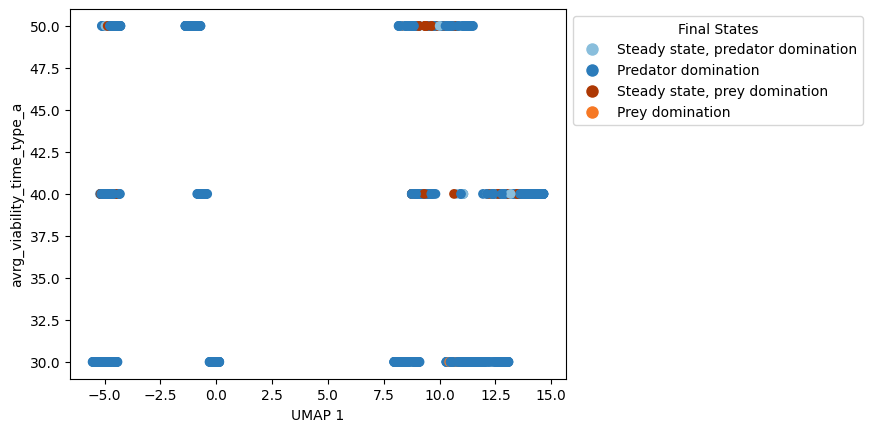

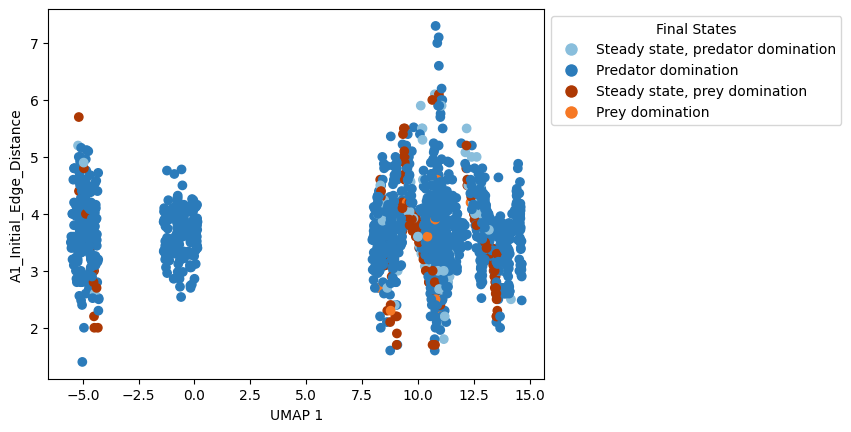

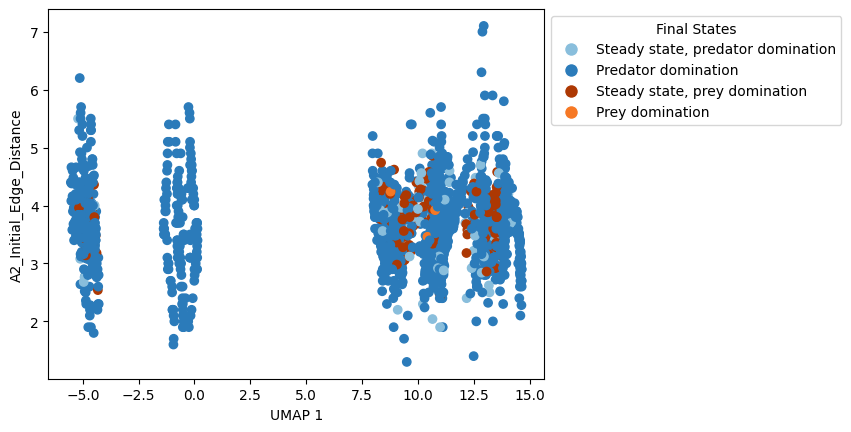

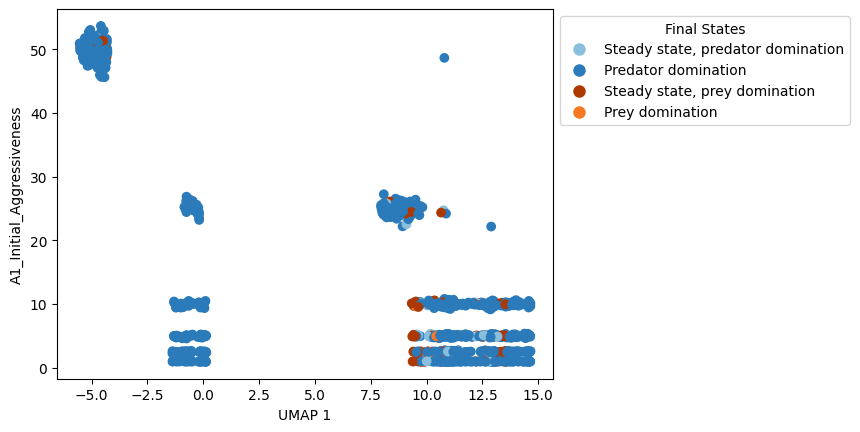

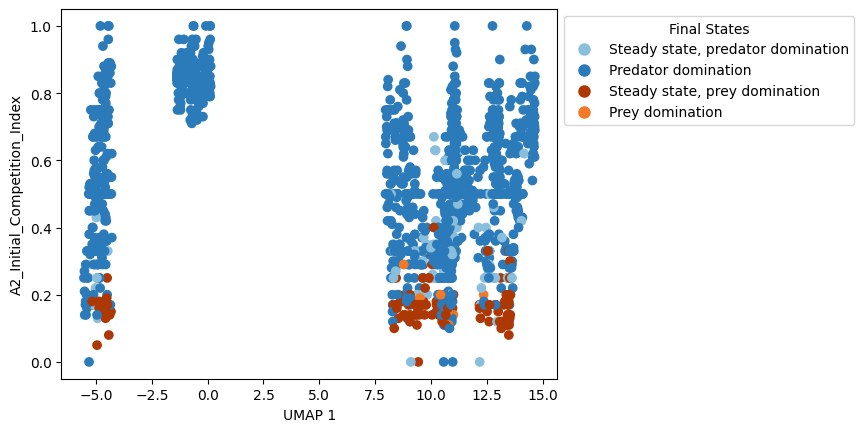

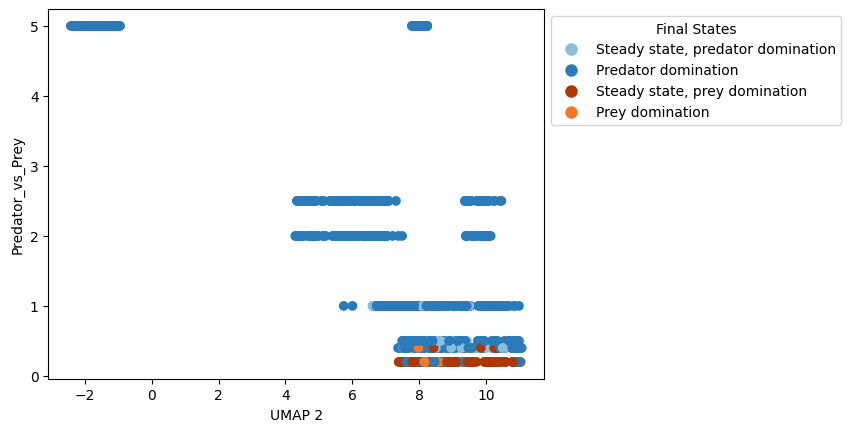

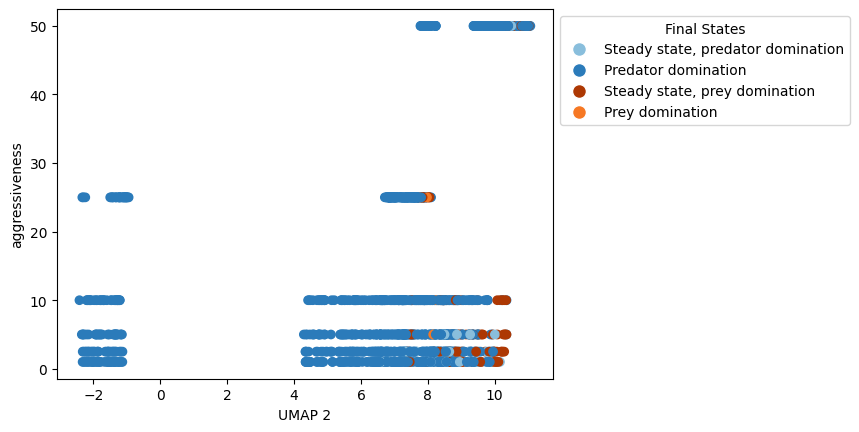

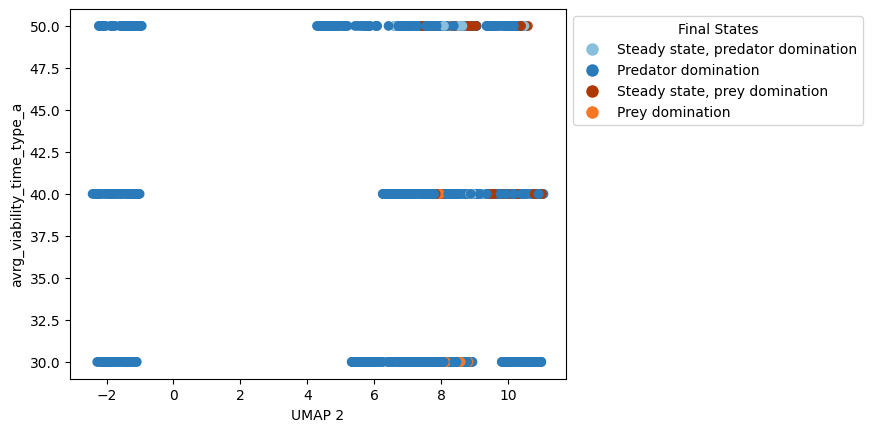

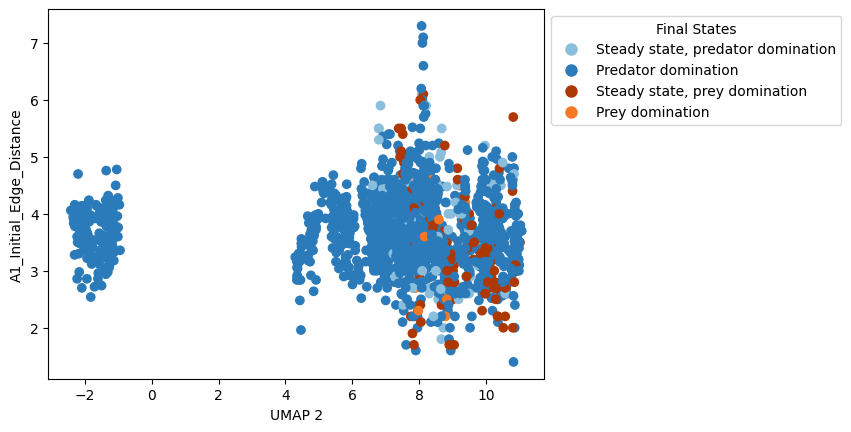

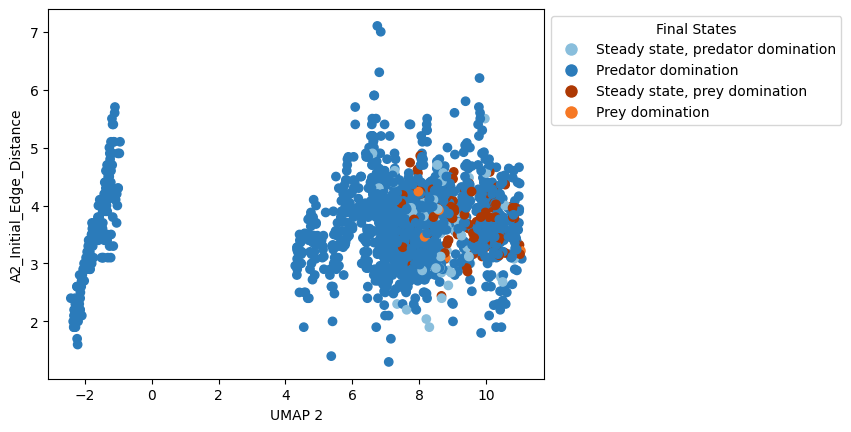

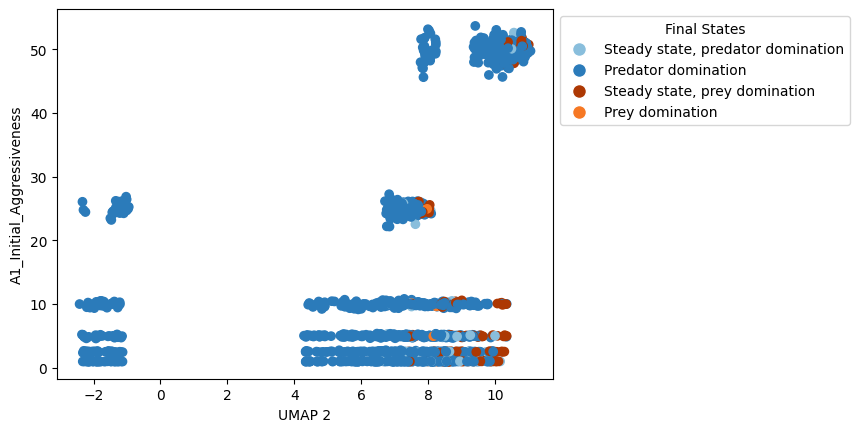

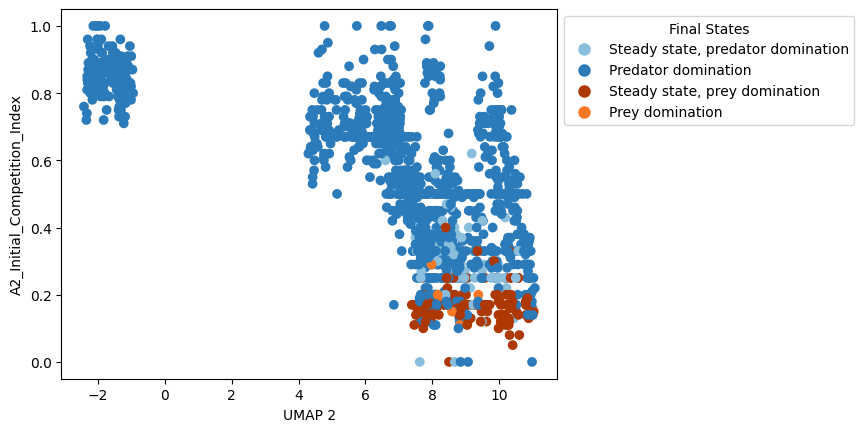

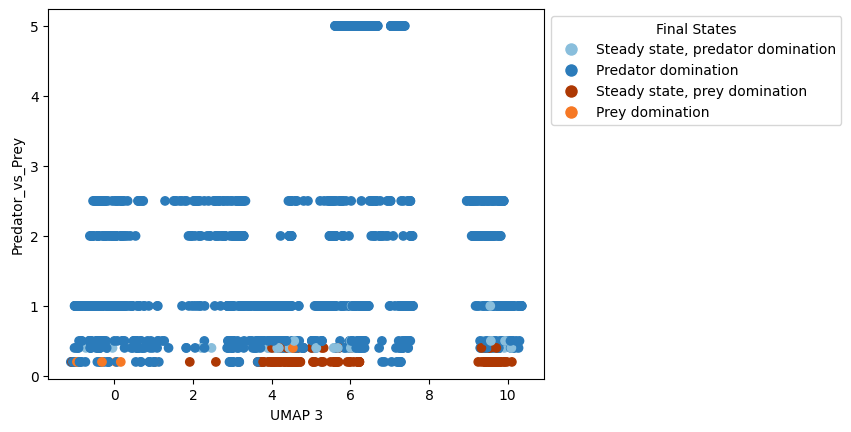

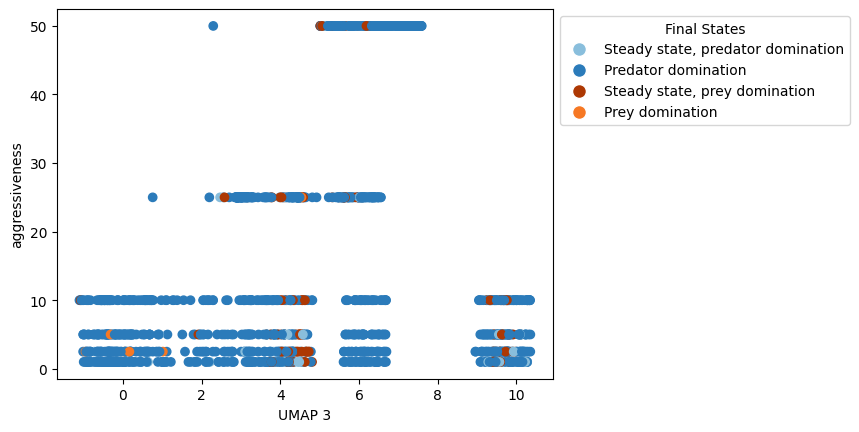

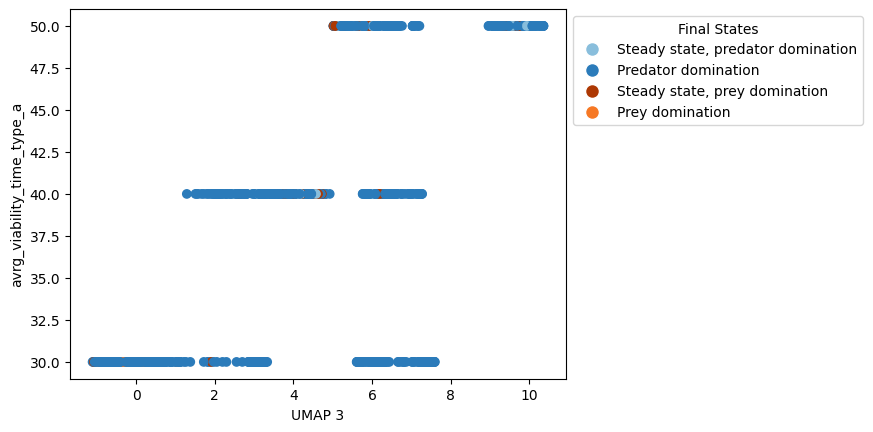

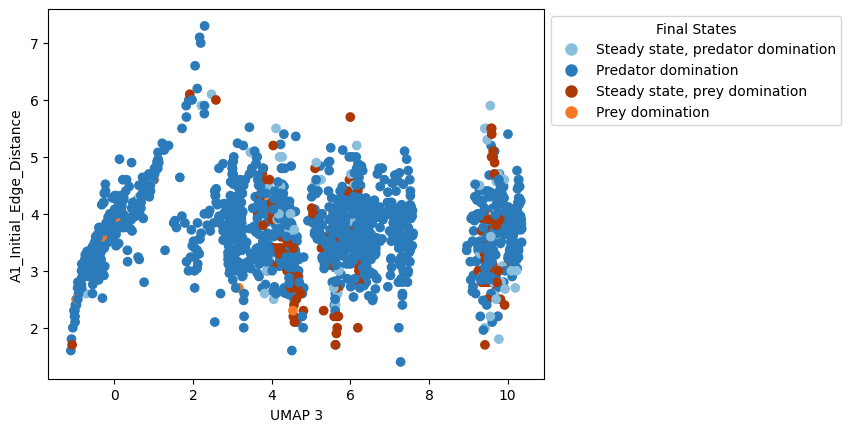

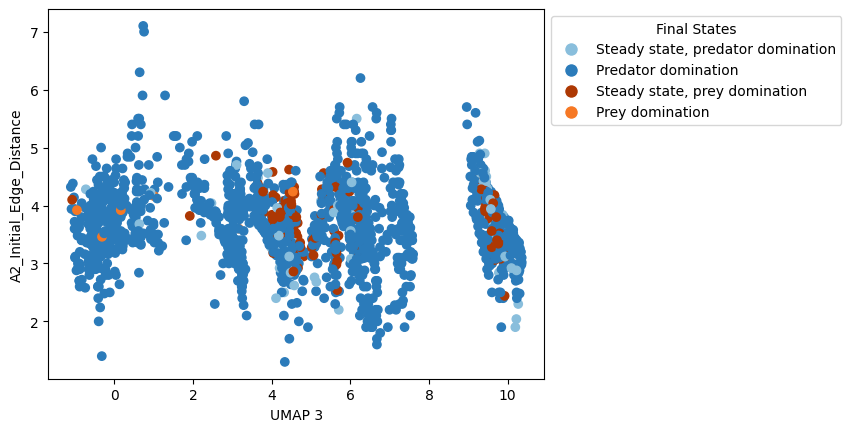

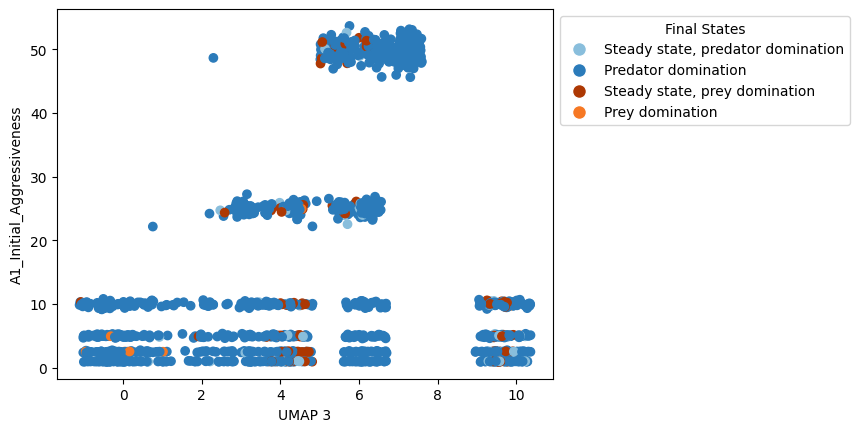

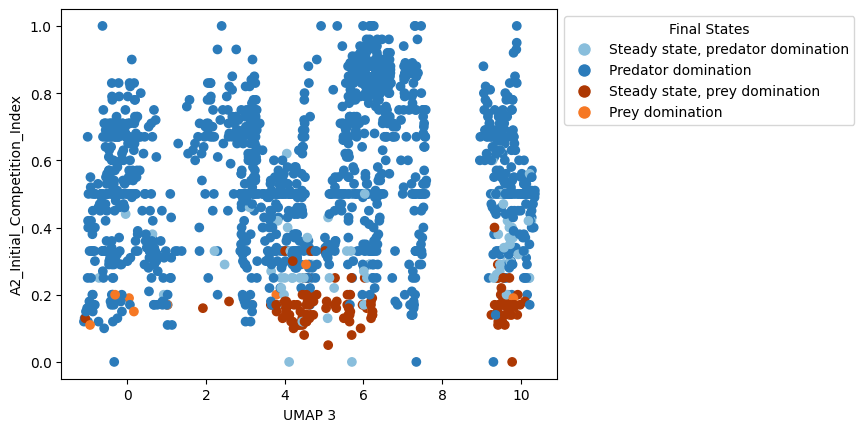

In [25]:
plot_embedding_vs_umap(embeddings[0], reduced_variable_set)

## Conclusions

- **Predator domination** is the largest final state due to it overpowering in the 1:1 ratio (514/540; rest **Steady state, predator domination**), which is the main ratio of the simulation (33% of all runs)
    - Ratios over 1:1 ensure **Predator domination** state
    - Ratio of 1:1 and smaller allow Prey survival
- Both **steady states** appear to be result of higher initial viability time
    - Decrease in the input viability pushes the simulation away from the steady state. However more towards **Preditor domination** and more rarely towards **Prey domination**
        - Generally the median initial competition index increases survival chances of the Prey and thus avoids **Preditor domination**. Therefore competition index might be the factor that tilts the balance towards one of the dominations if other parameters are relatively equal
            - Competition index strongly depends on the starting ratios
        - The distance to the edge could be another tilting factor, however its numbers are less consistnent. It should probably be quantified in a different way
- **Prey domination** only occurs at the two lowest ratios. Viability time and initial competition index are also low for it it to manifest. It is extremely seldom
- Initial ratio of 1:5 ensures most final sates containing alive preys (not **Prey domination**). Starting from 1:2.5 the balance starts quickly shifting towards the **Prey domination**
- Agresssiveness levels are less influential than expected, since all four final states occur with each of the six levels. The fluctuations of final states distributions are small: biggest change is a 9% increase of **Prey domination** is copred for 1% and 50% aggressiveness
    - This suggests that even high aggressiveness levels can be cancelled out by combinations of other parameters; f.e. high viability time + low ratio + small competition index
- **PCA analysis** shows that the Prey and Predator favoured states could be separated along the second PC. However there is no separate clusters observed
    - The first PC is dominated by the aggressiveness values and Prey's distance to the edge
        - The first contradicts the previous statement from the data analysis
        - The second provides more clearness into the role of the distance tp the edge in this simulation. It appears to be that in this context it could only matter if the prey is closer to the edge, which would support the statement from the original paper work
        - However the data points are separable on along the second PC and thus the role of the first PC could be downplayed
    - The second PC is dominated by the competition index and the intial ratios
- **UMAP analysis** did not provide any improvements in clustering and similarly to **PCA** highlighted the importance of the competition index



## Limitations

- Our assumptions are based on the final state and not on th dynamics of the populations. Not on how they come to that final state (too many scenarios to take into account)
- Quantify how viable are the bacteria that start the experiment, since their early death (which is not that rare) has an enormous effect on the simulation run. Initial competition index and ratios only inderectly provides a feeling for this measurement
- The model is relatively complex model and has a realistic behaviour through the interaction of multiple parameters
    - The trade off is that that, as we have seen it becomes less intuitive to understand how each of them effects the outcome individually
- The 1620 parameter combinations is a good start, focuses mainly on the main and intuitive parameter combinations. Would be interesting to have a batch with bigger parameter scope including less essential ones; f.e. grid width

